<a href="https://colab.research.google.com/github/sooyun1202/NLP/blob/main/LSTM%EB%AA%A8%EB%8D%B8_%ED%95%9C%EA%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!git clone https://github.com/e9t/nsmc.git

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 890kB 22.7MB/s 
     |████████████████████████████████| 2.9MB 35.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e26f4429aef2686c179d5bf5f45e349512cf2d5b18619b80ad5468d551b7ebd7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [2]:
import io
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# 모델에 사용할 데이터 불러오기
train_data = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test_data = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

In [4]:
# train_data [중복제거 및 정규표현식 적용]
train_data.drop_duplicates(subset=['document'], inplace=True)                           # document 열에서 중복인 내용이 있다면 중복 제거
train_data = train_data.dropna(how = 'any')                                             # Null 값이 존재하는 행 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")   # train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행
train_data['document'].replace('', np.nan, inplace=True)                                # Null값 재확인
train_data = train_data.dropna(how = 'any')                                             # 의미없는 데이터 제거

In [5]:
# trai_data 상위 3개 데이터 출력 후 확인
train_data[:3]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [6]:
# test_data [중복제거 및 정규표현식 적용]
test_data.drop_duplicates(subset = ['document'], inplace=True)                          # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")     # train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행
test_data['document'].replace('', np.nan, inplace=True)                                 # Null값 재확인
test_data = test_data.dropna(how='any')                                                 # Null 값이 존재하는 행 제거

In [7]:
# test_data 상위 3개 데이터 출력 후 확인
test_data[:3]

,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0


토큰화

In [8]:
!pip install konlpy     # konlpy install
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 43.7MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [9]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어정의

In [10]:
# train_data 에 대한 토큰화 / 불용어제거 진행
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)                    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [11]:
# test_data 에 대한 토큰화 / 불용어제거 진행
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)                    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

정수인코딩

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
threshold   = 3
total_cnt   = len(tokenizer.word_index) # 단어의 수
rare_cnt    = 0                         # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq  = 0                         # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq   = 0                         # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 묶음을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1

In [14]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2

In [15]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# 학습데이터와 테스트데이터를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [17]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [18]:
# 빈샘플 제거
X_train = np.delete(X_train, drop_train, axis=0) 
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


패딩

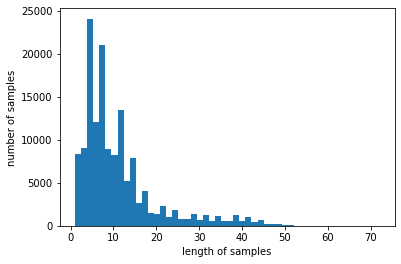

In [19]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1

In [21]:
max_len = 30
below_threshold_len(max_len, X_train)

In [22]:
# 샘플길이 맞추기
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

모델 생성

In [23]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [25]:
# 모델학습
print('모델학습시작')
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

모델학습시작
Epoch 1/15
1939/1939 [==============================] - 159s 81ms/step - loss: 0.4360 - acc: 0.7937 - val_loss: 0.3538 - val_acc: 0.8444

Epoch 00001: val_acc improved from -inf to 0.84441, saving model to best_model.h5
Epoch 2/15
1939/1939 [==============================] - 154s 79ms/step - loss: 0.3319 - acc: 0.8544 - val_loss: 0.3385 - val_acc: 0.8550

Epoch 00002: val_acc improved from 0.84441 to 0.85497, saving model to best_model.h5
Epoch 3/15
1939/1939 [==============================] - 155s 80ms/step - loss: 0.3024 - acc: 0.8719 - val_loss: 0.3285 - val_acc: 0.8577

Epoch 00003: val_acc improved from 0.85497 to 0.85772, saving model to best_model.h5
Epoch 4/15
1939/1939 [==============================] - 154s 80ms/step - loss: 0.2820 - acc: 0.8821 - val_loss: 0.3315 - val_acc: 0.8575

Epoch 00004: val_acc did not improve from 0.85772
Epoch 5/15
1939/1939 [==============================] - 154s 80ms/step - loss: 0.2636 - acc: 0.8922 - val_loss: 0.3330 - val_acc: 0.8592

E

In [26]:
loaded_model = load_model('best_model.h5')

데이터 적용

In [27]:
# 긍정 / 부정 판단하는 함수
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True)                      # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence])                  # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len)                      # 패딩
  score = float(loaded_model.predict(pad_new))                            # 예측
  
  if(score > 0.5):
    return 1
  else:
    return 0

In [28]:
# Test적용할 파일 입력teData = files.upload()
teData = files.upload()
te_data = pd.read_csv(io.BytesIO(teData['ko_data.csv']), encoding='CP949')

# 적용해야할 파일 [중복제거 및 정규표현식 적용]
#te_data.drop_duplicates(subset=['Sentence'], inplace=True)                          # document 열에서 중복인 내용이 있다면 중복 제거
te_data = te_data.dropna(how = 'any')                                               # Null 값이 존재하는 행 제거
te_data['Sentence'] = te_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","  ")     # train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행
te_data['Sentence'].replace(' ', np.nan, inplace=True)                               # Null값 재확인


Saving ko_data.csv to ko_data.csv


In [29]:
# Test 적용파일의 긍정 / 부정 판단 후 새로운 label 지정하여 기입
result = []

for sentence in te_data['Sentence']:
  result.append(sentiment_predict(sentence))

del te_data['Sentence']
te_data['Predicted'] = result

In [30]:
# Test 적용파일을 CSV파일로 변환하여 다운로드진행
te_data.to_csv("resultTest_LSTM.csv", sep=",", index=False, encoding='ms949')
print('finish')

finish


참고: https://wikidocs.net/44249